# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import classes.file_loader as file_loader

# Data Preprocessing

## Loading Files

In [4]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [5]:
classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  classic_raw_df.fillna(method = "ffill", inplace=True)
c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precarity_raw_df.fillna(method = "ffill", inplace=True)


In [6]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [7]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [15]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)
augmented_classic_df.to_csv("augmented_classic_df.csv", index=False)
augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.173378
2,2023-04-26,7.267931
3,2023-04-27,7.178813
4,2023-04-28,7.216256
...,...,...
446,2025-01-07,7.958602
447,2025-01-08,7.988975
448,2025-01-09,7.985047
449,2025-01-10,8.003714


In [16]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)
augmented_precarity_df.to_csv("augmented_precarity_df.csv", index=False)
augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.238753
2,2023-04-26,7.381707
3,2023-04-27,7.331491
4,2023-04-28,7.436027
...,...,...
446,2025-01-07,10.052526
447,2025-01-08,9.932173
448,2025-01-09,10.297676
449,2025-01-10,9.964157


## Plotting the augmented dataframes 

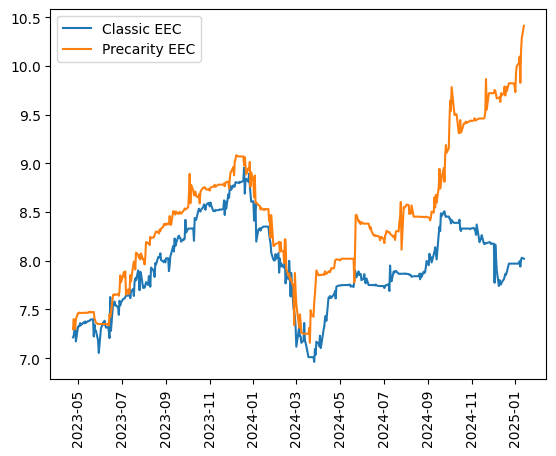

In [10]:
plt.figure()

plt.plot(augmented_classic_df["Date"], augmented_classic_df["SPOT"], label = "Classic EEC")
plt.plot(augmented_precarity_df["Date"], augmented_precarity_df["SPOT"], label = "Precarity EEC")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

# Data forecasting

## Tests

### Stationnarity

From the Graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [11]:
diff_classic_df = augmented_classic_df.copy()
diff_classic_df["Delta"] = diff_classic_df["SPOT"] - diff_classic_df["SPOT"].shift(1)
diff_classic_df.dropna(inplace = True)
diff_classic_df

,Date,SPOT,Delta
1,2023-04-25,7.232094,0.019378
2,2023-04-26,7.287849,0.055755
3,2023-04-27,7.319169,0.031320
4,2023-04-28,7.170806,-0.148363
5,2023-05-01,7.321166,0.150360
...,...,...,...
446,2025-01-07,7.995065,0.025065
447,2025-01-08,7.939391,-0.055674
448,2025-01-09,8.009683,0.070292
449,2025-01-10,8.030482,0.020799


In [12]:
diff_precarity_df = augmented_classic_df.copy()
diff_precarity_df["Delta"] = diff_precarity_df["SPOT"] - diff_precarity_df["SPOT"].shift(1)
diff_precarity_df.dropna(inplace = True)
diff_precarity_df

,Date,SPOT,Delta
1,2023-04-25,7.232094,0.019378
2,2023-04-26,7.287849,0.055755
3,2023-04-27,7.319169,0.031320
4,2023-04-28,7.170806,-0.148363
5,2023-05-01,7.321166,0.150360
...,...,...,...
446,2025-01-07,7.995065,0.025065
447,2025-01-08,7.939391,-0.055674
448,2025-01-09,8.009683,0.070292
449,2025-01-10,8.030482,0.020799


## ARMA

## GRU

## LSTM